In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi
import torch
# from lightning.pytorch.loggers import CSVLogger
import session_info
import warnings
torch.set_float32_matmul_precision('high')
from pyprojroot.here import here

# Setting some parameters
warnings.filterwarnings("ignore")

adata = ad.read(here("output/integration/Immune cells/Immune_cells_scVI_integrated_10_latent.h5ad"))

[rank: 0] Global seed set to 0
/scratch/groups/singlecell/software/anaconda3/envs/csf/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/scratch/groups/singlecell/software/anaconda3/envs/csf/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


# Compute neighbors and clusters

In [2]:
# clustering with several resolutions
sc.pp.neighbors(adata, use_rep="X_scVI")
resolutions_to_explore = [0.05, 0.1, 0.5, 1, 1.5, 2]
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    sc.tl.leiden(adata, resolution=res, key_added=leiden_cluster)

In [3]:
sc.tl.umap(adata)#, init = 'X_scVI') ???

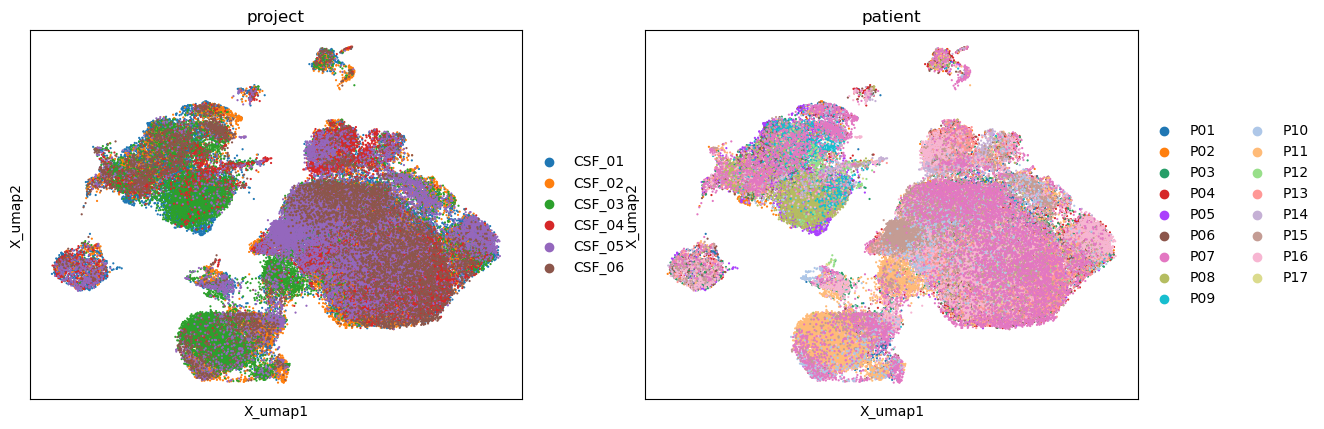

In [4]:
sc.pl.embedding(adata, basis="X_umap", color=['project', 'patient'], show=True, size=10)


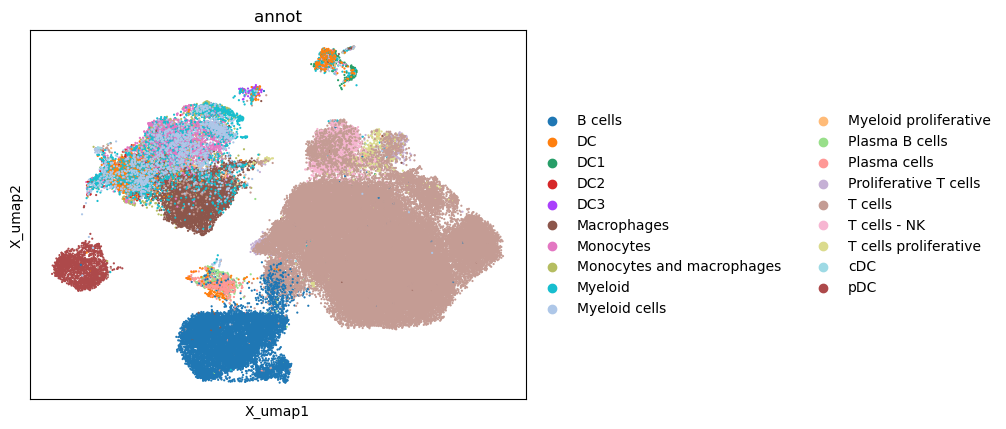

In [5]:
sc.pl.embedding(adata, basis="X_umap", color='annot', show=True, size=10)

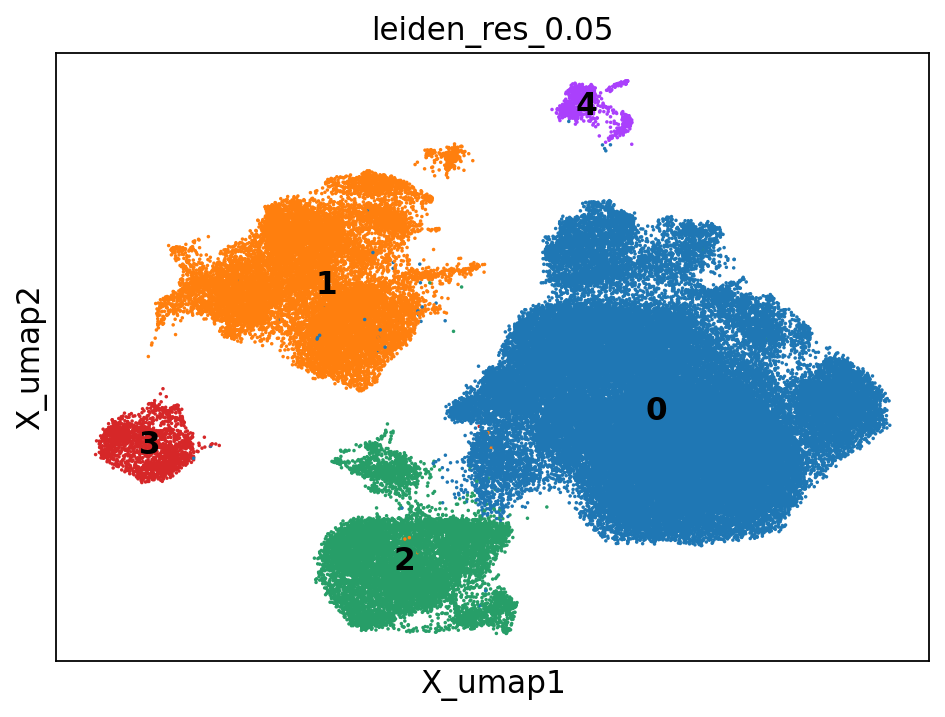

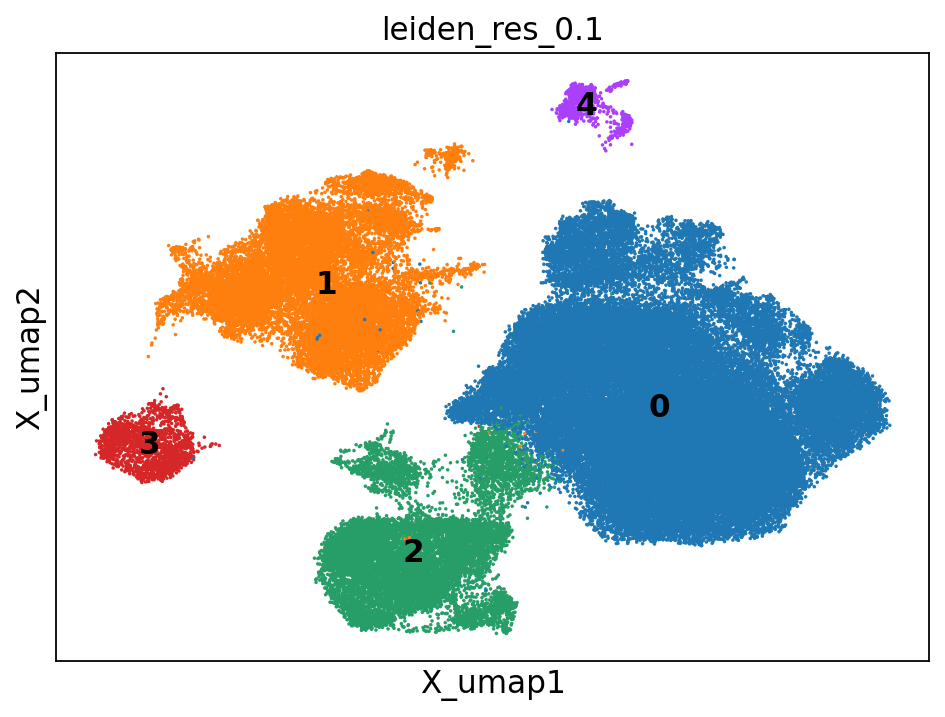

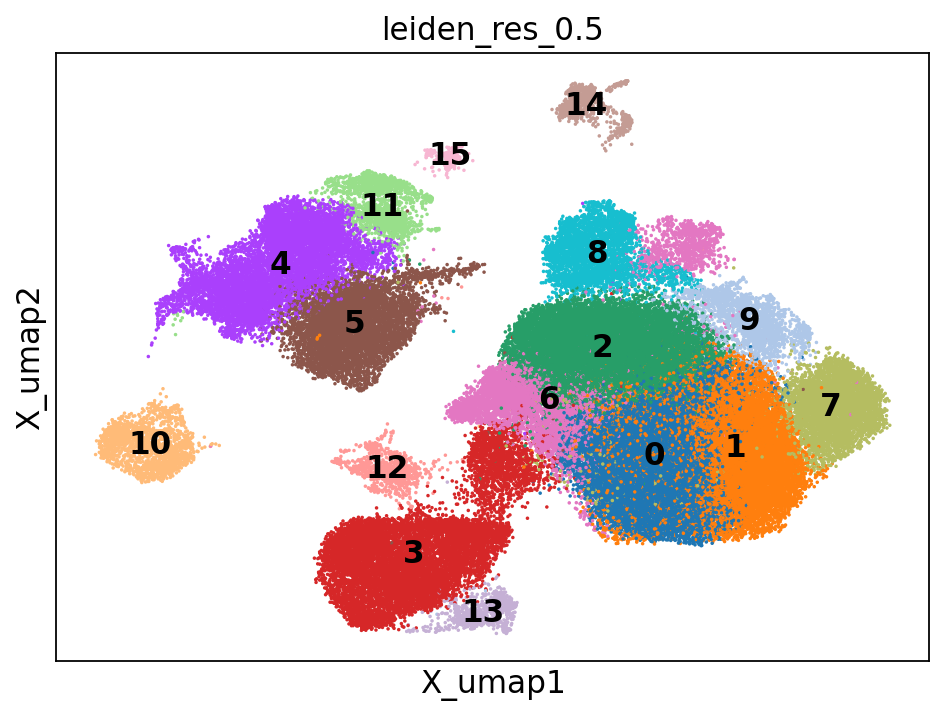

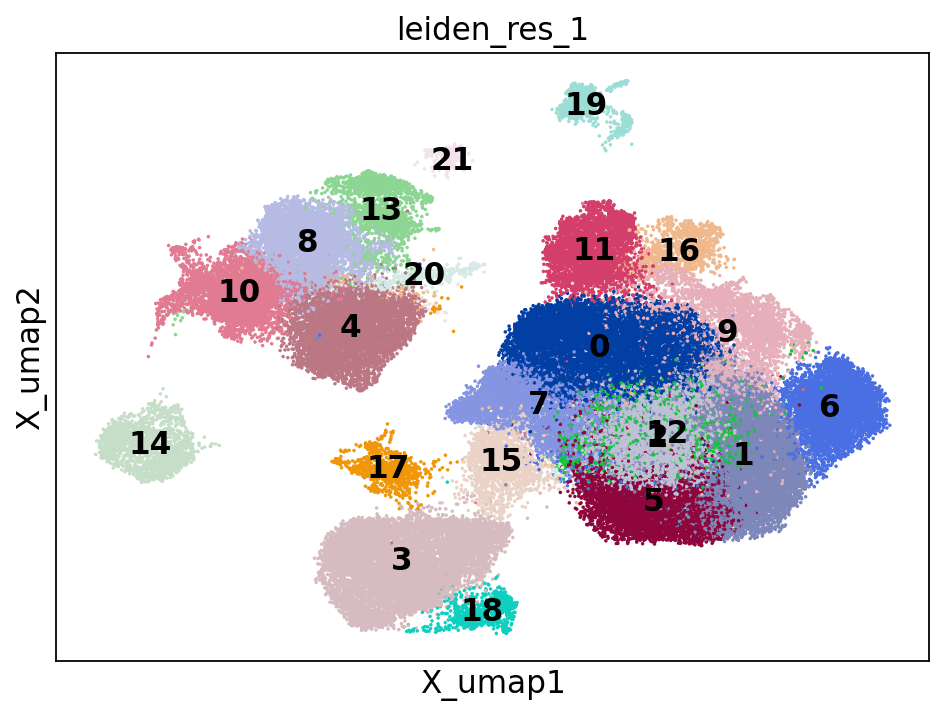

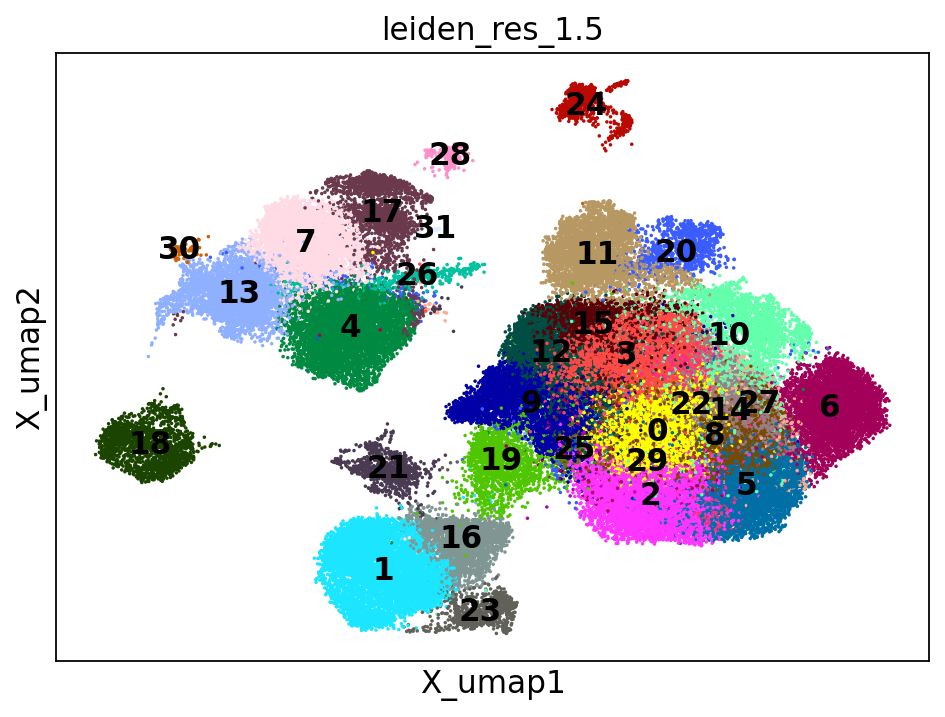

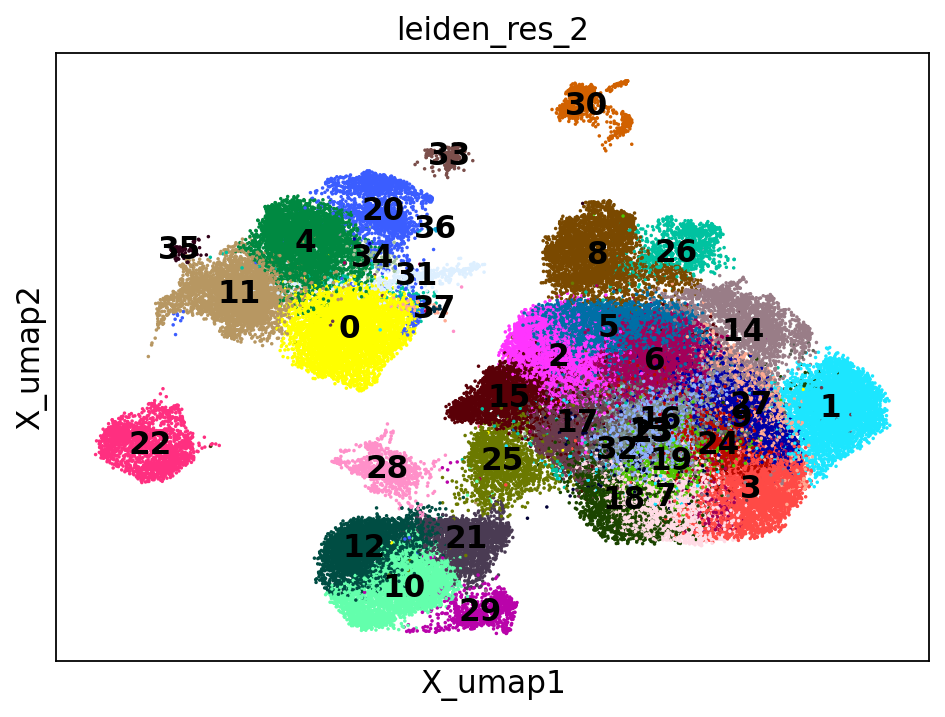

In [6]:
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    sc.set_figure_params(figsize=(7, 5))
    sc.pl.embedding(adata, basis="X_umap", color=leiden_cluster, show=True, size=10, legend_loc="on data")

# Log-normalize data

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Finding marker genes

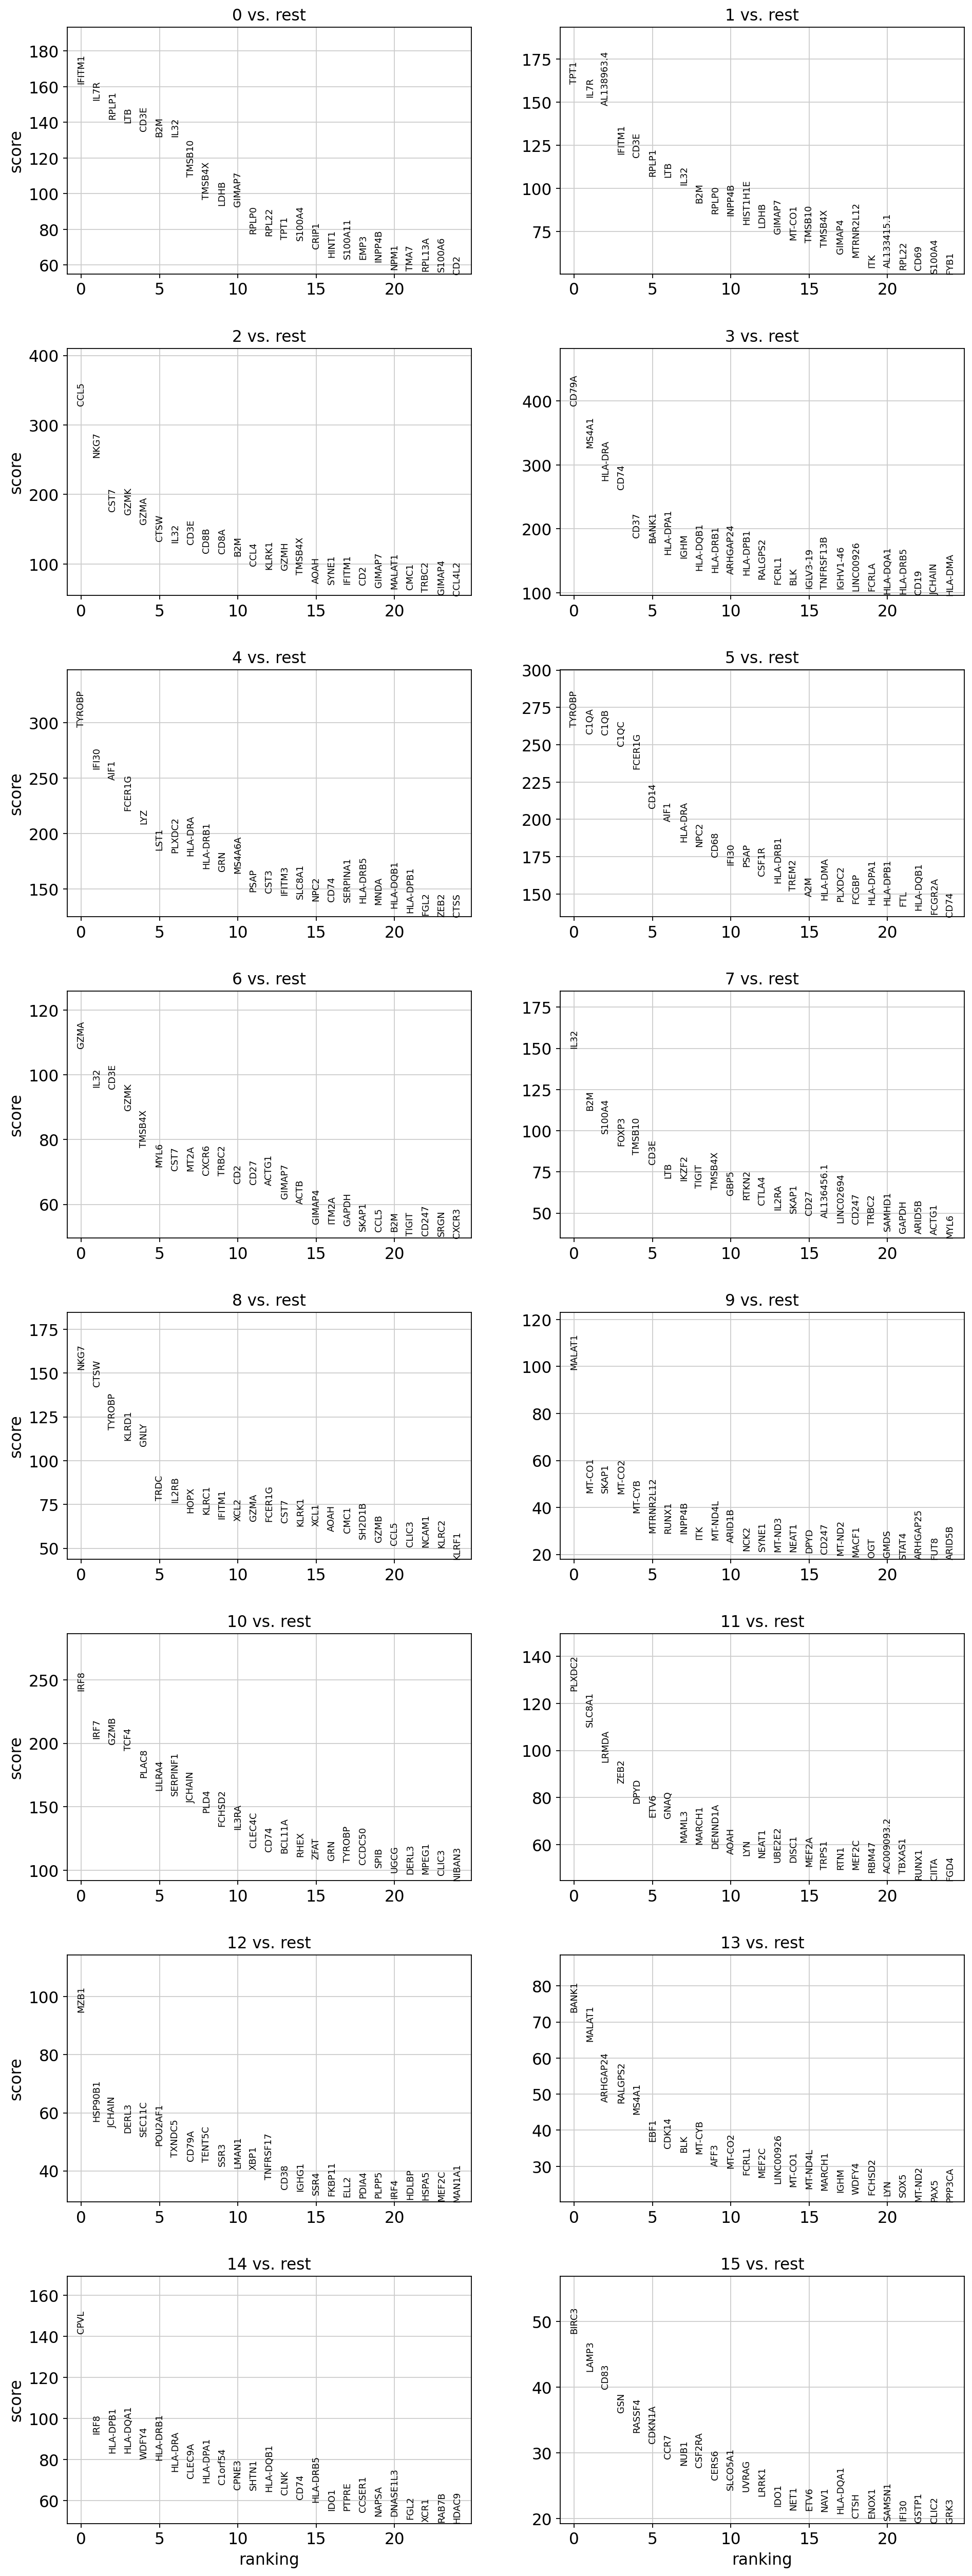

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.5', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=2)

# Compute markers

In [9]:
# set folder to save results
folder_for_immunologist = here('output/integration/Immune cells/markers/')
# Compute markers
sc.tl.rank_genes_groups(adata, 
                        groupby='leiden_res_0.5', 
                        method='wilcoxon', 
                        use_raw = False)
# Save markers
rank_genesDF = sc.get.rank_genes_groups_df(adata, group=None)
rank_genesDF.to_csv(here('{}/marker_genes_res0.5_scVI.csv'.format(folder_for_immunologist)))
rank_genes_excel_path = here('{}/marker_genes_res0.5_scVI.xlsx'.format(folder_for_immunologist))
unique_groups = rank_genesDF["group"].unique()
with pd.ExcelWriter(rank_genes_excel_path, engine="openpyxl") as writer:
    for group in unique_groups:
        group_rank_genesDF = rank_genesDF[rank_genesDF["group"] == group]
        group_rank_genesDF = group_rank_genesDF[group_rank_genesDF["logfoldchanges"] > 0.2]
        group_rank_genesDF.to_excel(writer, sheet_name=group, index=False)

In [10]:
adata.write(here("output/integration/Immune cells/Immune_cells_scVI_clustered.h5ad"), compression="gzip")

In [11]:
pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names).to_csv(here("output/integration/Immune cells/Immune_cells_scVI_UMAP.csv"))

In [12]:
pd.DataFrame(adata.obs[["leiden_res_" + str(num) for num in resolutions_to_explore]]).to_csv(here("output/integration/Immune cells/Immune_cells_scVI_clusters.csv"))